# Recon Mol

In [ ]:
import numpy as np
import sys
sys.path.append('..')
from core.utils import misc, reconstruct, transforms
from core.evaluation.utils import eval_atom_type, scoring_func, analyze, eval_bond_length

sample_id = 0 # up to 100
num_step_interval = 1
num_steps = len(traj[0]['pos_traj'])

molist = []
sample_list = []
theta_list = []

for res in [traj[sample_id]]: # num_pockets
    pred_pos_traj, pred_v_traj = res['pos_traj'], res['v_traj']
    theta_pos_traj, theta_v_traj = res['theta_pos_traj'], res['theta_v_traj']

    for k in range(0, num_steps, num_steps // num_step_interval):
        pred_pos, pred_v = pred_pos_traj[k], pred_v_traj[k]
        sample_list.append({'pos': pred_pos, 'type': pred_v})
        pred_v = pred_v.argmax(dim=-1) # change stored v from pmf to index

        theta_pos, theta_v = theta_pos_traj[k], theta_v_traj[k]
        theta_list.append({'pos': theta_pos, 'type': theta_v})
        pred_pos = pred_pos.numpy().astype(np.float64)
        pred_v = pred_v.numpy().astype(np.int64)
        pred_atom_type = transforms.get_atomic_number_from_index(pred_v, mode='add_aromatic')

        try:
            pred_aromatic = transforms.is_aromatic_from_index(pred_v, mode='add_aromatic')
            mol = reconstruct.reconstruct_from_generated(pred_pos, pred_atom_type, pred_aromatic, sanitize=False)
            molist.append(mol)


        except Exception as e:
            print(e)
            continue


# Visualize gradient direction (cos sim)

## For backward correction

In [1]:
# plot an overall comparison

import numpy as np
import torch
import os
import sys
sys.path.append('..')
from core.config.config import Config

def cosine_similarity(a, b):
    a = a.flatten()
    b = b.flatten()
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)


result_dir = '../../logs/qiukeyue_bfn_molopt/correction/traj/test_outputs'
timestamps = os.listdir(result_dir)
strategy2timestamps = {}

exp2label = {
    'vanilla': 'B.C. steps = 1',
    'vanilla_back_50': 'B.C. steps = 50',
    'vanilla_back_100': 'B.C. steps = 100',
    'vanilla_back_130': 'B.C. steps = 130',
    'end_back_pmf': 'B.C. steps = 200'
}

for t in timestamps:
    config = os.path.join(result_dir, t, 'config.yaml')
    if not os.path.exists(config): continue
    config = Config(config)
    cfg = config.evaluation
    if not hasattr(cfg, 'save_traj') or not hasattr(cfg, 'objective') or not hasattr(cfg, 'pos_grad_weight') or not hasattr(cfg, 'type_grad_weight'): continue
    if not cfg.save_traj: continue
    if cfg.objective != 'vina_sa': continue
    if cfg.pos_grad_weight != 50 or cfg.type_grad_weight != 50: continue
    if cfg.sample_num_atoms != 'prior': continue
    strategy = config.dynamics.sampling_strategy
    if strategy not in exp2label.keys(): continue
    strategy2timestamps.setdefault(strategy, []).append(t)

print(strategy2timestamps)

exp2sim = {}
for exp in ['vanilla', 'vanilla_back_50', 'vanilla_back_100', 'vanilla_back_130', 'end_back_pmf']:
    timestamp = strategy2timestamps[exp][0]
    traj = torch.load(os.path.join(result_dir, timestamp, 'traj_outputs.pt'), map_location='cpu')

    vina_list = []
    sa_list = []
    vina_pos_grad_list = []
    vina_type_grad_list = []
    sa_pos_grad_list = []
    sa_type_grad_list = []

    vina_pos_grad_sim_list = []
    vina_type_grad_sim_list = []
    sa_pos_grad_sim_list = []
    sa_type_grad_sim_list = []
    for id, res in enumerate(traj): # num_pockets
        vina_traj, sa_traj = res['vina'], res['sa']
        vina_pos_grad_traj, vina_type_grad_traj = res['vina_pos_grad'], res['vina_type_grad']
        # grad_traj: n_steps, n_atoms, 3
        sa_pos_grad_traj, sa_type_grad_traj = res['sa_pos_grad'], res['sa_type_grad']
        vina_list.append(np.array(vina_traj))
        sa_list.append(np.array(sa_traj))
        vina_pos_grad_list.append(vina_pos_grad_traj)
        vina_type_grad_list.append(vina_type_grad_traj)
        sa_pos_grad_list.append(sa_pos_grad_traj)
        sa_type_grad_list.append(sa_type_grad_traj)

        vina_pos_grad_sim_traj = [cosine_similarity(vina_pos_grad_traj[i], vina_pos_grad_traj[i+1]) for i in range(len(vina_pos_grad_traj) - 1)]
        vina_type_grad_sim_traj = [cosine_similarity(vina_type_grad_traj[i], vina_type_grad_traj[i+1]) for i in range(len(vina_type_grad_traj) - 1)]
        sa_pos_grad_sim_traj = [cosine_similarity(sa_pos_grad_traj[i], sa_pos_grad_traj[i+1]) for i in range(len(sa_pos_grad_traj) - 1)]
        sa_type_grad_sim_traj = [cosine_similarity(sa_type_grad_traj[i], sa_type_grad_traj[i+1]) for i in range(len(sa_type_grad_traj) - 1)]
        vina_pos_grad_sim_list.append(np.array(vina_pos_grad_sim_traj))
        vina_type_grad_sim_list.append(np.array(vina_type_grad_sim_traj))
        sa_pos_grad_sim_list.append(np.array(sa_pos_grad_sim_traj))
        sa_type_grad_sim_list.append(np.array(sa_type_grad_sim_traj))
        

    vina_list = np.array(vina_list)
    sa_list = np.array(sa_list)
    # vina_pos_grad_list = np.array(vina_pos_grad_list)
    # vina_type_grad_list = np.array(vina_type_grad_list)
    # sa_pos_grad_list = np.array(sa_pos_grad_list)
    # sa_type_grad_list = np.array(sa_type_grad_list)
    vina_pos_grad_sim_list = np.array(vina_pos_grad_sim_list)
    vina_type_grad_sim_list = np.array(vina_type_grad_sim_list)
    sa_pos_grad_sim_list = np.array(sa_pos_grad_sim_list)
    sa_type_grad_sim_list = np.array(sa_type_grad_sim_list)

    # print(vina_list.shape, sa_list.shape)
    # print(len(vina_pos_grad_list), len(vina_pos_grad_list[0]), len(vina_pos_grad_list[0][0]), len(vina_pos_grad_list[0][0][0]))
    # pos_grad: n_pockets, n_steps, n_atoms, 3
    # type_grad: n_pockets, n_steps, n_atoms, n_atom_types

    exp2sim[exp] = {
        'vina_pos_grad_sim_list': vina_pos_grad_sim_list,
        'vina_type_grad_sim_list': vina_type_grad_sim_list,
        'sa_pos_grad_sim_list': sa_pos_grad_sim_list,
        'sa_type_grad_sim_list': sa_type_grad_sim_list
    }

print(exp2sim.keys())

{'vanilla_back_130': ['20240922-090645', '20240921-220944', '20240921-233727', '20240921-222552', '20240922-035648', '20240921-220550', '20240921-222943', '20240921-231843', '20240922-012330'], 'vanilla_back_50': ['20240922-133848'], 'vanilla_back_100': ['20240922-133808'], 'vanilla': ['20240922-133719'], 'end_back_pmf': ['20240922-133138']}
dict_keys(['vanilla', 'vanilla_back_50', 'vanilla_back_100', 'vanilla_back_130', 'end_back_pmf'])


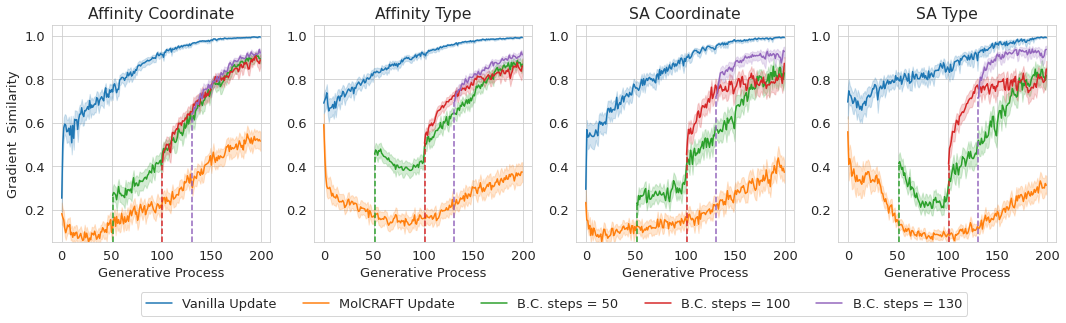

In [8]:
# plot the similarity of gradients
import matplotlib.pyplot as plt

plt.figure(figsize=(6*3, 4))

data = []
exp2label = {
    'vanilla': 'Vanilla Update',
    'end_back_pmf': 'MolCRAFT Update',
    'vanilla_back_50': 'B.C. steps = 50',
    'vanilla_back_100': 'B.C. steps = 100',
    'vanilla_back_130': 'B.C. steps = 130'
}

for exp in ['vanilla', 'end_back_pmf', 'vanilla_back_50', 'vanilla_back_100', 'vanilla_back_130']:
    vina_pos_grad_sim_list = exp2sim[exp]['vina_pos_grad_sim_list']
    vina_type_grad_sim_list = exp2sim[exp]['vina_type_grad_sim_list']
    sa_pos_grad_sim_list = exp2sim[exp]['sa_pos_grad_sim_list']
    sa_type_grad_sim_list = exp2sim[exp]['sa_type_grad_sim_list']

    if 'vanilla_back' in exp:
        K = int(exp.split('_')[-1]) + 1
        # crop the list to [K:]
        vina_pos_grad_sim_list = vina_pos_grad_sim_list[:, K:]
        vina_type_grad_sim_list = vina_type_grad_sim_list[:, K:]
        sa_pos_grad_sim_list = sa_pos_grad_sim_list[:, K:]
        sa_type_grad_sim_list = sa_type_grad_sim_list[:, K:]
    else:
        K = 0
    
    sample_steps = np.arange(K, K + len(vina_pos_grad_sim_list.mean(axis=0)))
    for k in range(len(sample_steps)):
        for i in range(len(vina_pos_grad_sim_list)):
            data.append({
                'sample_steps': sample_steps[k],
                'vina_pos_grad_sim_list': vina_pos_grad_sim_list[i][k],
                'vina_type_grad_sim_list': vina_type_grad_sim_list[i][k],
                'sa_pos_grad_sim_list': sa_pos_grad_sim_list[i][k],
                'sa_type_grad_sim_list': sa_type_grad_sim_list[i][k],
                'exp': exp2label[exp]
            })

import seaborn as sns
import pandas as pd
data = pd.DataFrame(data)

sns.set_style("whitegrid")

plt.subplot(1, 4, 1)
sns.lineplot(x='sample_steps', y='vina_pos_grad_sim_list', hue='exp', data=data)
plt.legend([], [], frameon=False)
plt.ylim(0.05, 1.05)
# add vline for the start of backward update
plt.axvline(x=51, linestyle='--', color='tab:green', ymax=exp2sim['vanilla_back_50']['vina_pos_grad_sim_list'].mean(axis=0)[51] - 0.05)
plt.axvline(x=101, linestyle='--', color='tab:red', ymax=exp2sim['vanilla_back_100']['vina_pos_grad_sim_list'].mean(axis=0)[101] - 0.05)
plt.axvline(x=131, linestyle='--', color='tab:purple', ymax=exp2sim['vanilla_back_130']['vina_pos_grad_sim_list'].mean(axis=0)[131] - 0.05)
plt.xlabel('Generative Process')
plt.ylabel('Gradient  Similarity')
plt.title('Affinity Coordinate')

plt.subplot(1, 4, 2)
sns.lineplot(x='sample_steps', y='vina_type_grad_sim_list', hue='exp', data=data)
plt.legend([], [], frameon=False)
plt.ylim(0.05, 1.05)
plt.axvline(x=51, linestyle='--', color='tab:green', ymax=exp2sim['vanilla_back_50']['vina_type_grad_sim_list'].mean(axis=0)[51] - 0.05)
plt.axvline(x=101, linestyle='--', color='tab:red', ymax=exp2sim['vanilla_back_100']['vina_type_grad_sim_list'].mean(axis=0)[101] - 0.05)
plt.axvline(x=131, linestyle='--', color='tab:purple', ymax=exp2sim['vanilla_back_130']['vina_type_grad_sim_list'].mean(axis=0)[131] - 0.05)
plt.xlabel('Generative Process')
plt.ylabel('')
plt.title('Affinity Type')

plt.subplot(1, 4, 3)
sns.lineplot(x='sample_steps', y='sa_pos_grad_sim_list', hue='exp', data=data)
plt.legend([], [], frameon=False)
plt.ylim(0.05, 1.05)
plt.axvline(x=51, linestyle='--', color='tab:green', ymax=exp2sim['vanilla_back_50']['sa_pos_grad_sim_list'].mean(axis=0)[51] - 0.05)
plt.axvline(x=101, linestyle='--', color='tab:red', ymax=exp2sim['vanilla_back_100']['sa_pos_grad_sim_list'].mean(axis=0)[101] - 0.05)
plt.axvline(x=131, linestyle='--', color='tab:purple', ymax=exp2sim['vanilla_back_130']['sa_pos_grad_sim_list'].mean(axis=0)[131] - 0.05)
plt.xlabel('Generative Process')
plt.ylabel('')
plt.title('SA Coordinate')

plt.subplot(1, 4, 4)
sns.lineplot(x='sample_steps', y='sa_type_grad_sim_list', hue='exp', data=data)
plt.ylim(0.05, 1.05)
plt.axvline(x=51, linestyle='--', color='tab:green', ymax=exp2sim['vanilla_back_50']['sa_type_grad_sim_list'].mean(axis=0)[51] - 0.05)
plt.axvline(x=101, linestyle='--', color='tab:red', ymax=exp2sim['vanilla_back_100']['sa_type_grad_sim_list'].mean(axis=0)[101] - 0.05)
plt.axvline(x=131, linestyle='--', color='tab:purple', ymax=exp2sim['vanilla_back_130']['sa_type_grad_sim_list'].mean(axis=0)[131] - 0.05)
plt.xlabel('Generative Process')
plt.ylabel('')
plt.title('SA Type')

# Create one legend
plt.legend(loc='upper center', bbox_to_anchor=(-1.3, -0.2), ncol=5)

# Adjust layout to prevent overlap
plt.rcParams.update({'font.size': 13, 'legend.fontsize': 13, 'axes.labelsize': 13})
plt.savefig('gradient_similarity.pdf', bbox_inches='tight', dpi=300)
# plt.show()